#### Loading libraries and data

In [1]:
import torch

import zipfile
from pathlib import Path

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset

import random
import cv2

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


#### Loading data from kaggle

In [3]:
# !kaggle datasets download -d sbaghbidi/human-faces-object-detection

 98% 486M/498M [00:04<00:00, 93.8MB/s]
100% 498M/498M [00:04<00:00, 111MB/s] 


Moving dataset to the data folder

In [6]:
# !mkdir data
# !mv human-faces-object-detection.zip data

In [14]:
data_path = Path("data/")
image_path = data_path / "human-faces-object-detection"
with zipfile.ZipFile(data_path / "human-faces-object-detection.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

Unzipping...


In [19]:
image_path = data_path / "human-faces-object-detection" / "images"

In [8]:
y_labels = pd.read_csv('/content/data/human-faces-object-detection/faces.csv')

#### Analyzing images

In [9]:
num_faces = np.unique(y_labels.groupby('image_name').count()['width'])

In [10]:
print(f'In the dataset there is a wide range of # of faces ranging from {num_faces[0]} to {num_faces[-1]}')

In the dataset there is a wide range of # of faces ranging from 1 to 12


#### Creating Dataloader

Path to images

In [20]:
images_paths = list(image_path.glob('*.jpg'))

In [51]:
class FacesDataset(Dataset):

    def __init__(self, images_path, dataset, height=64, width=64):

        ''' Loading dataset
        images_path: path where images are stored
        dataset: dataframe where image names and box bounds are stored
        height: height used to resize the image
        width: width used to resize the image
        images_list: list where all image paths are stored
        bboxes: list where all the bounding boxes are stored

        '''
        self.images_path = Path(images_path)
        self.dataset = dataset
        self.height = height
        self.width = width
        self.n_samples = dataset.shape[0]

        self.images_list = sorted(list(images_path.glob('*.jpg')))
        self.images_names = [image.name for image in self.images_list]
        self.bboxes_names = dataset['image_name'].tolist()

   # cut down to only images present in dataset

        self.images = []
        for i in self.bboxes_names:
            for j in self.images_names:
                if i == j:
                    self.images.append(i)


    def __getitem__(self, index):

        image_name = self.images[index]
        image_path = self.images_path / image_name

        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # by default in cv2 represents image in BGR order, so we have to convert it back to RGB
        img = cv2.resize(img, (self.width, self.height)).astype(np.float32)
        img /= 255.0 # normalizing values
        img = np.transpose(img, (2, 0, 1)) # converting to HHWC format

        image_labels = self.dataset[self.dataset['image_name'] == image_name]

        imgs, bbox = [], []
        for i in range(len(image_labels)):
            cur_height = image_labels['height'].iloc[i]
            cur_width = image_labels['width'].iloc[i]

            x0 = (image_labels['x0'].iloc[i] / cur_width) * self.width
            y0 = (image_labels['y0'].iloc[i] / cur_height) * self.height
            x1 = (image_labels['x1'].iloc[i] / cur_width) * self.width
            y1 = (image_labels['y1'].iloc[i] / cur_height) * self.height

            bbox = [1, x0, y0, x1, y1]
            break

        return img, bbox

    def __len__(self):
        return self.n_samples

In [52]:
batch_size = 3
dataset = FacesDataset(image_path, y_labels, 126, 126)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, \
                        shuffle=True)

In [57]:
batch = next(iter(dataloader))

In [58]:
batch[0][0].shape

torch.Size([3, 126, 126])

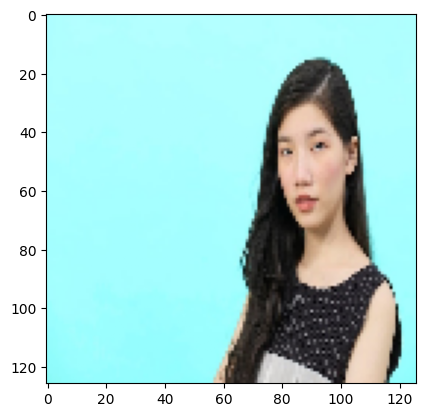

In [61]:
img = np.transpose(batch[0][1], (1, 2, 0))
plt.imshow(img)
plt.show()